In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [2]:
import yfinance as yf

In [3]:
#Download Tata motors data from yahoo finance
df = yf.download('BHARTIARTL.NS')

[*********************100%***********************]  1 of 1 completed


In [4]:
#first 5 samples
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-07-01,15.631986,16.297667,15.379487,15.976303,14.976347,831759
2002-07-02,15.379487,16.343575,15.379487,16.297667,15.277597,664008
2002-07-03,16.527210,16.527210,16.045168,16.136984,15.126970,564071
2002-07-04,16.412437,16.641981,16.182894,16.527210,15.492772,1127138
2002-07-05,16.091076,16.274712,15.609032,15.700850,14.718132,886627


In [5]:
# to check dates in index
df.index

DatetimeIndex(['2002-07-01', '2002-07-02', '2002-07-03', '2002-07-04',
               '2002-07-05', '2002-07-08', '2002-07-09', '2002-07-10',
               '2002-07-11', '2002-07-12',
               ...
               '2023-06-15', '2023-06-16', '2023-06-19', '2023-06-20',
               '2023-06-21', '2023-06-22', '2023-06-23', '2023-06-26',
               '2023-06-27', '2023-06-30'],
              dtype='datetime64[ns]', name='Date', length=5216, freq=None)

In [6]:
df.shape

(5216, 6)

In [7]:
# to check features or columns 
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [8]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-22,836.700012,843.500000,834.700012,842.799988,842.799988,4380046
2023-06-23,844.000000,862.750000,841.349976,854.799988,854.799988,7667340
2023-06-26,857.349976,857.349976,846.349976,851.950012,851.950012,4431992
2023-06-27,856.500000,871.349976,853.599976,864.900024,864.900024,5533649
2023-06-30,880.000000,883.000000,867.049988,878.750000,878.750000,5216052


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5216 entries, 2002-07-01 to 2023-06-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5216 non-null   float64
 1   High       5216 non-null   float64
 2   Low        5216 non-null   float64
 3   Close      5216 non-null   float64
 4   Adj Close  5216 non-null   float64
 5   Volume     5216 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 285.2 KB


In [10]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [11]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

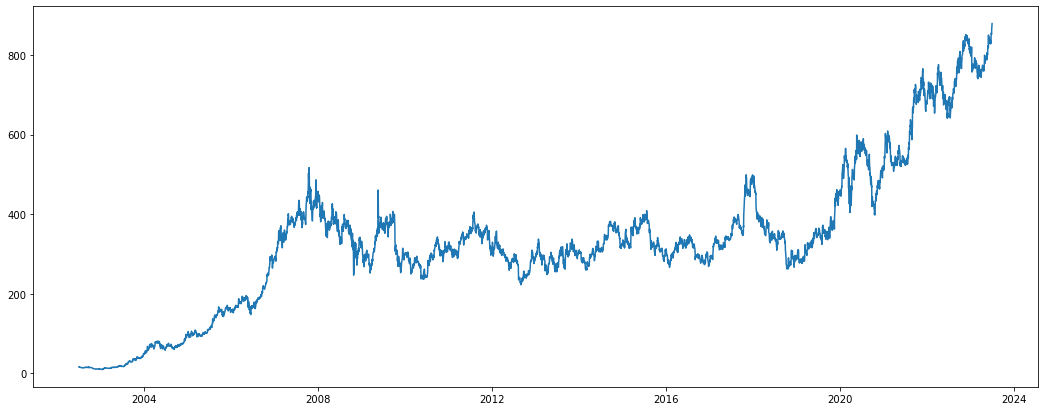

In [12]:
# plot a graph
plt1 = plt.figure(figsize=(18,7))
import matplotlib.pyplot as plt
plt.plot(df['Close'])

In [13]:
# check open price for first day and close price for last day
print("Starting price: ",df.iloc[0][0])
print("Ending price: ", df.iloc[-1][3])

Starting price:  15.631985664367676
Ending price:  878.75


In [14]:
# check start date and end date in our dataset
print("Starting date: ",df.index[0])
print("Ending date: ", df.index[-1])

Starting date:  2002-07-01 00:00:00
Ending date:  2023-06-30 00:00:00


In [15]:
# drop some columns except 'close ' columns as we are going to do prediction only on closing price
df.drop(columns=['High','Low','Adj Close','Volume'],inplace=True)

In [16]:
df.head()

,Open,Close
Date,,
2002-07-01,15.631986,15.976303
2002-07-02,15.379487,16.297667
2002-07-03,16.527210,16.136984
2002-07-04,16.412437,16.527210
2002-07-05,16.091076,15.700850


In [17]:
# LSTM are sensitive to the scale of the data. so we apply MinMax scaler 
# Preprocess the data
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df['Close']).reshape(-1,1))

In [18]:
df1

array([[0.00742065],
       [0.00779036],
       [0.0076055 ],
       ...,
       [0.96916791],
       [0.98406627],
       [1.        ]])

In [19]:
# Split data into training and testing sets
train_size=int(len(df1)*0.7)
test_size=len(df1)-train_size
train_data,test_data=df1[0:train_size,:],df1[train_size:len(df1),:1]

In [20]:
train_size,test_size

(3651, 1565)

In [21]:
train_data

array([[0.00742065],
       [0.00779036],
       [0.0076055 ],
       ...,
       [0.3759178 ],
       [0.36477361],
       [0.37475583]])

In [22]:
# convert an array of values into a dataset matrix
#function to create new dataset which is required by LSTM.giving sequence of data to our LSTM model
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), numpy.array(dataY)

In [23]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
import numpy
time_step = 20
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [24]:
X_train

array([[0.00742065, 0.00779036, 0.0076055 , ..., 0.00530801, 0.00551927,
        0.00514956],
       [0.00779036, 0.0076055 , 0.00805444, ..., 0.00551927, 0.00514956,
        0.00514956],
       [0.0076055 , 0.00805444, 0.00710375, ..., 0.00514956, 0.00514956,
        0.00512315],
       ...,
       [0.32336588, 0.31792585, 0.33102421, ..., 0.37935083, 0.38553029,
        0.37232629],
       [0.31792585, 0.33102421, 0.3541576 , ..., 0.38553029, 0.37232629,
        0.37037212],
       [0.33102421, 0.3541576 , 0.35685123, ..., 0.37232629, 0.37037212,
        0.3759178 ]])

In [25]:
y_train

array([0.00514956, 0.00512315, 0.00559849, ..., 0.37037212, 0.3759178 ,
       0.36477361])

In [26]:
X_test

array([[0.37222068, 0.36598838, 0.36524895, ..., 0.34681616, 0.34898165,
        0.35331256],
       [0.36598838, 0.36524895, 0.37090027, ..., 0.34898165, 0.35331256,
        0.36002017],
       [0.36524895, 0.37090027, 0.37047773, ..., 0.35331256, 0.36002017,
        0.3588054 ],
       ...,
       [0.93005256, 0.93384903, 0.93062778, ..., 0.94529604, 0.95426955,
        0.95864125],
       [0.93384903, 0.93062778, 0.9668095 , ..., 0.95426955, 0.95864125,
        0.97244667],
       [0.93062778, 0.9668095 , 0.94155707, ..., 0.95864125, 0.97244667,
        0.96916791]])

In [27]:
print(X_train.shape) 

(3630, 20)


In [28]:
print(y_train.shape)

(3630,)


In [29]:
print(X_test.shape)

(1544, 20)


In [30]:
print(ytest.shape)

(1544,)


In [31]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [32]:
X_train.shape

(3630, 20, 1)

In [33]:
X_train

array([[[0.00742065],
        [0.00779036],
        [0.0076055 ],
        ...,
        [0.00530801],
        [0.00551927],
        [0.00514956]],

       [[0.00779036],
        [0.0076055 ],
        [0.00805444],
        ...,
        [0.00551927],
        [0.00514956],
        [0.00514956]],

       [[0.0076055 ],
        [0.00805444],
        [0.00710375],
        ...,
        [0.00514956],
        [0.00514956],
        [0.00512315]],

       ...,

       [[0.32336588],
        [0.31792585],
        [0.33102421],
        ...,
        [0.37935083],
        [0.38553029],
        [0.37232629]],

       [[0.31792585],
        [0.33102421],
        [0.3541576 ],
        ...,
        [0.38553029],
        [0.37232629],
        [0.37037212]],

       [[0.33102421],
        [0.3541576 ],
        [0.35685123],
        ...,
        [0.37232629],
        [0.37037212],
        [0.3759178 ]]])

In [34]:
### Create the Stacked LSTM model
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model

In [35]:
#model=Sequential()
#model.add(LSTM(100, input_shape = (time_step , 1)))
#model.add(Dropout(0.2))
#model.add(LSTM(200, input_shape=(time_step , 1), return_sequences=False))
#model.add(Dropout(0.5))
#model.add(Dense(100,kernel_initializer='uniform',activation='sigmoid'))        
#model.add(Dense(1,kernel_initializer='uniform',activation='sigmoid'))
#model.compile(loss='mse',optimizer='adam')

model=Sequential()
model.add(LSTM(50,input_shape=(time_step,1)))
model.add(Dropout(0.2))
#model.add(LSTM(50,return_sequences=True))
#model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=32,verbose=1)

Epoch 1/100
114/114 [==============================] - 5s 22ms/step - loss: 0.0070 - val_loss: 4.9900e-04
Epoch 2/100
114/114 [==============================] - 2s 18ms/step - loss: 0.0010 - val_loss: 6.2572e-04
Epoch 3/100
114/114 [==============================] - 2s 18ms/step - loss: 7.8786e-04 - val_loss: 4.0387e-04
Epoch 4/100
114/114 [==============================] - 2s 21ms/step - loss: 7.1855e-04 - val_loss: 9.8517e-04
Epoch 5/100
114/114 [==============================] - 3s 22ms/step - loss: 7.0360e-04 - val_loss: 6.1120e-04
Epoch 6/100
114/114 [==============================] - 2s 17ms/step - loss: 6.2919e-04 - val_loss: 7.8363e-04
Epoch 7/100
114/114 [==============================] - 2s 19ms/step - loss: 6.1483e-04 - val_loss: 8.6782e-04
Epoch 8/100
114/114 [==============================] - 2s 19ms/step - loss: 5.9025e-04 - val_loss: 6.8426e-04
Epoch 9/100
114/114 [==============================] - 2s 19ms/step - loss: 5.1507e-04 - val_loss: 0.0014
Epoch 10/100
114/114 [

114/114 [==============================] - 2s 19ms/step - loss: 1.7354e-04 - val_loss: 3.2708e-04
Epoch 76/100
114/114 [==============================] - 4s 32ms/step - loss: 1.8127e-04 - val_loss: 3.7418e-04
Epoch 77/100
114/114 [==============================] - 2s 18ms/step - loss: 1.7070e-04 - val_loss: 2.1280e-04
Epoch 78/100
114/114 [==============================] - 2s 16ms/step - loss: 1.6787e-04 - val_loss: 3.0295e-04
Epoch 79/100
114/114 [==============================] - 2s 17ms/step - loss: 1.8380e-04 - val_loss: 1.9963e-04
Epoch 80/100
114/114 [==============================] - 2s 18ms/step - loss: 1.8170e-04 - val_loss: 4.1809e-04
Epoch 81/100
114/114 [==============================] - 2s 18ms/step - loss: 1.6441e-04 - val_loss: 3.3342e-04
Epoch 82/100
114/114 [==============================] - 2s 18ms/step - loss: 1.7122e-04 - val_loss: 3.2608e-04
Epoch 83/100
114/114 [==============================] - 2s 18ms/step - loss: 1.7665e-04 - val_loss: 2.9114e-04
Epoch 84/100
1

In [38]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

49/49 [==============================] - 0s 6ms/step


In [39]:
train_predict

array([[0.01130542],
       [0.01122913],
       [0.01118833],
       ...,
       [0.37244198],
       [0.37026575],
       [0.37504074]], dtype=float32)

In [40]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [41]:
train_predict

array([[ 19.353043],
       [ 19.286726],
       [ 19.251263],
       ...,
       [333.26157 ],
       [331.36996 ],
       [335.52048 ]], dtype=float32)

In [42]:
test_predict

array([[315.7731 ],
       [321.05087],
       [320.56775],
       ...,
       [812.26355],
       [824.80334],
       [818.5115 ]], dtype=float32)

In [43]:
ytest

array([0.36002017, 0.3588054 , 0.35009078, ..., 0.97244667, 0.96916791,
       0.98406627])

In [44]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))


279.6681363739614

In [45]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

530.470447431146

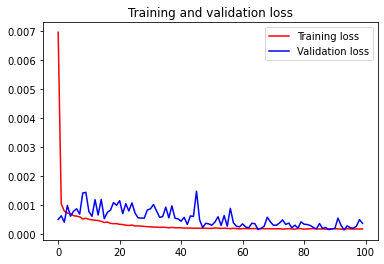

<Figure size 432x288 with 0 Axes>

In [46]:
### plot a graph for training and validation loss to visualize the results of model training

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')
plt.figure()


plt.show()

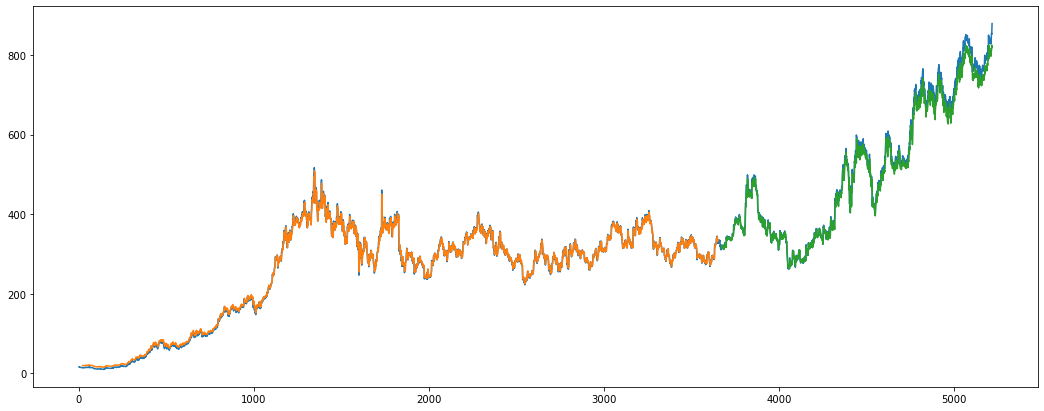

In [47]:
# shift train predictions for plotting
look_back=20
trainPredictPlot = numpy.empty_like(df1)  ## to take same shape and sata type of df1
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt1 = plt.figure(figsize=(18,7))
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [48]:
ytest

array([0.36002017, 0.3588054 , 0.35009078, ..., 0.97244667, 0.96916791,
       0.98406627])

In [49]:
test_predict

array([[315.7731 ],
       [321.05087],
       [320.56775],
       ...,
       [812.26355],
       [824.80334],
       [818.5115 ]], dtype=float32)

In [50]:
test_predict1 = test_predict.flatten()

In [51]:
len(ytest)

1544

In [52]:
test_predict1

array([315.7731 , 321.05087, 320.56775, ..., 812.26355, 824.80334,
       818.5115 ], dtype=float32)

In [53]:
ytest1 = ytest.flatten()

In [54]:
ytest1 = ytest1.reshape(1,-1)

In [55]:
ytest1

array([[0.36002017, 0.3588054 , 0.35009078, ..., 0.97244667, 0.96916791,
        0.98406627]])

In [56]:
ytest2 = scaler.inverse_transform(ytest1)

In [57]:
ytest2

array([[322.4642334 , 321.4083252 , 313.83337402, ..., 854.79998779,
        851.95001221, 864.90002441]])

In [58]:
ytest2 = ytest2.flatten()

In [59]:
len(ytest2)

1544

In [64]:
df2 = df.iloc[3672:,:]

In [65]:
len(df2)

1544

In [66]:
df2.head()

,Open,Close
Date,,
2017-03-31,321.362427,321.408325
2017-04-03,317.689728,313.833374
2017-04-05,314.889282,316.312439
2017-04-06,314.935181,313.833374
2017-04-07,315.899261,316.496094


In [67]:
df2['predicted'] = test_predict1

In [68]:
df2.head(20)

,Open,Close,predicted
Date,,,
2017-03-31,321.362427,321.408325,315.773102
2017-04-03,317.689728,313.833374,321.050873
2017-04-05,314.889282,316.312439,320.567749
2017-04-06,314.935181,313.833374,314.140259
2017-04-07,315.899261,316.496094,316.001495
2017-04-10,319.801514,317.414276,314.063812
2017-04-11,314.935181,321.546051,316.183258
2017-04-12,318.607880,322.096985,317.081696
2017-04-13,321.362427,312.410187,320.676086


In [69]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1544 entries, 2017-03-31 to 2023-06-30
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1544 non-null   float64
 1   Close      1544 non-null   float64
 2   predicted  1544 non-null   float32
dtypes: float32(1), float64(2)
memory usage: 42.2 KB


In [70]:
df2.tail()

,Open,Close,predicted
Date,,,
2023-06-22,836.700012,842.799988,803.597229
2023-06-23,844.000000,854.799988,810.360901
2023-06-26,857.349976,851.950012,812.263550
2023-06-27,856.500000,864.900024,824.803345
2023-06-30,880.000000,878.750000,818.511475


In [71]:
df2['temp_signal'] = df2['predicted'] - df2['Close']

In [72]:
df2.head()

,Open,Close,predicted,temp_signal
Date,,,,
2017-03-31,321.362427,321.408325,315.773102,-5.635223
2017-04-03,317.689728,313.833374,321.050873,7.217499
2017-04-05,314.889282,316.312439,320.567749,4.255310
2017-04-06,314.935181,313.833374,314.140259,0.306885
2017-04-07,315.899261,316.496094,316.001495,-0.494598


In [73]:
df2['signal'] = df2['temp_signal'].apply(lambda x:1 if x>0 else 0)

In [74]:
df2.head()

,Open,Close,predicted,temp_signal,signal
Date,,,,,
2017-03-31,321.362427,321.408325,315.773102,-5.635223,0
2017-04-03,317.689728,313.833374,321.050873,7.217499,1
2017-04-05,314.889282,316.312439,320.567749,4.255310,1
2017-04-06,314.935181,313.833374,314.140259,0.306885,1
2017-04-07,315.899261,316.496094,316.001495,-0.494598,0


In [75]:
df2.drop(columns='temp_signal',inplace = True)

In [76]:
df2.head()

,Open,Close,predicted,signal
Date,,,,
2017-03-31,321.362427,321.408325,315.773102,0
2017-04-03,317.689728,313.833374,321.050873,1
2017-04-05,314.889282,316.312439,320.567749,1
2017-04-06,314.935181,313.833374,314.140259,1
2017-04-07,315.899261,316.496094,316.001495,0


In [77]:
signal = list(df2['signal'])

In [78]:
signal

[0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,


In [79]:
signal.insert(0,999)

In [80]:
signal

[999,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0

In [81]:
len(df2)

1544

In [82]:
len(signal)

1545

In [83]:
signal.pop()

0

In [84]:
len(signal)

1544

In [85]:
new_signal = np.array(signal)

In [86]:
new_signal

array([999,   0,   1, ...,   0,   0,   0])

In [87]:
df2['new_signal'] = new_signal

In [88]:
df2.head()

,Open,Close,predicted,signal,new_signal
Date,,,,,
2017-03-31,321.362427,321.408325,315.773102,0,999
2017-04-03,317.689728,313.833374,321.050873,1,0
2017-04-05,314.889282,316.312439,320.567749,1,1
2017-04-06,314.935181,313.833374,314.140259,1,1
2017-04-07,315.899261,316.496094,316.001495,0,1


In [89]:
df2.drop(columns = 'signal',inplace = True)

In [90]:
df3 = df2[df2['new_signal']==1]

In [91]:
df3.head()

,Open,Close,predicted,new_signal
Date,,,,
2017-04-05,314.889282,316.312439,320.567749,1
2017-04-06,314.935181,313.833374,314.140259,1
2017-04-07,315.899261,316.496094,316.001495,1
2017-04-17,314.751556,313.374268,321.403900,1
2017-04-18,312.180634,311.078827,313.138336,1


In [92]:
df3['profit_loss'] = df3['Close'] - df3['Open']

In [93]:
df3.head()

,Open,Close,predicted,new_signal,profit_loss
Date,,,,,
2017-04-05,314.889282,316.312439,320.567749,1,1.423157
2017-04-06,314.935181,313.833374,314.140259,1,-1.101807
2017-04-07,315.899261,316.496094,316.001495,1,0.596832
2017-04-17,314.751556,313.374268,321.403900,1,-1.377289
2017-04-18,312.180634,311.078827,313.138336,1,-1.101807


In [94]:
df3['profit_loss'].sum()

138.91555786132812

In [95]:
df4 = df2[df2['new_signal']==0]

In [96]:
df4['profit_loss'] = df4['Open'] - df4['Close']

In [97]:
df4.head()

,Open,Close,predicted,new_signal,profit_loss
Date,,,,,
2017-04-03,317.689728,313.833374,321.050873,0,3.856354
2017-04-10,319.801514,317.414276,314.063812,0,2.387238
2017-04-11,314.935181,321.546051,316.183258,0,-6.610870
2017-04-12,318.607880,322.096985,317.081696,0,-3.489105
2017-04-13,321.362427,312.410187,320.676086,0,8.952240


In [98]:
df2.head()

,Open,Close,predicted,new_signal
Date,,,,
2017-03-31,321.362427,321.408325,315.773102,999
2017-04-03,317.689728,313.833374,321.050873,0
2017-04-05,314.889282,316.312439,320.567749,1
2017-04-06,314.935181,313.833374,314.140259,1
2017-04-07,315.899261,316.496094,316.001495,1


In [99]:
df2.tail()

,Open,Close,predicted,new_signal
Date,,,,
2023-06-22,836.700012,842.799988,803.597229,0
2023-06-23,844.000000,854.799988,810.360901,0
2023-06-26,857.349976,851.950012,812.263550,0
2023-06-27,856.500000,864.900024,824.803345,0
2023-06-30,880.000000,878.750000,818.511475,0


In [100]:
df4['profit_loss'].sum()

937.9796142578125

In [101]:
Total_profit = df4['profit_loss'].sum() + df3['profit_loss'].sum()

In [102]:
Total_profit

1076.8951721191406

In [103]:
# check open price for first day and close price for last day
print("Starting price: ",df2.iloc[0][0])
print("Ending price: ", df2.iloc[-1][2])

Starting price:  321.3624267578125
Ending price:  818.511474609375


In [104]:
# total profit if buy and hold

buy_hold_profit = df2.iloc[-1][2] - df2.iloc[0][0]
buy_hold_profit

497.1490478515625

In [105]:
# excess profit generated by algo model

excess_profit = Total_profit - buy_hold_profit
excess_profit

579.7461242675781

In [106]:
# excess profit in percent

excess_profit_percent = (excess_profit *100)/Total_profit
excess_profit_percent

53.83496363222982

In [107]:
len(df3)

438

In [108]:
len(df4)

1105

In [109]:
len(df2)

1544